# Dissecting cell types for anatomical structures - Lung Epithelial Cells (advanced)

This how-to walks through the process of extracting cell types for anatomical structures.
It illustrates some of the challenges and nuances of ontology extraction in domains such as anatomy.

In theory it should be as simple as selecting a structure (e.g lung or the respiratory airway) and then selecting the cell types that are part of that structure. In practice, the way that ontologies are constructed renders results unsatisfactory:

- The results are often incomplete because more ubiquitous cell types may not be axiomatized as part of a structure.
- The results contain many redundancies because ontologies don't populate things at consistent "levels"

For this example, we'll work through lung epithelial cells.

An example of a biologist-friendly structure we might want to extract:

 ![img](../images/lung-cells-src.png)

## Initial exploration and motivation

As a motivating example, let's look at `goblet cell` (CL:0000160) in CL. For now we're going to use the command line, but later in this guide we'll explore the python interface.

We'll look at is-a and part-of ancestors of this cell type

In [1]:
!runoak -i sqlite:obo:cl viz -p i,p "goblet cell" -o output/goblet-cell.png

![img](output/goblet-cell.png)

What might be surprising to people not familiar with ontologies is the generic placement. 

## Initial setup

We'll require some core OAK libraries, as well as pandas

In [2]:
from oaklib import get_adapter
from oaklib.query import subclass_of, descendant_of, non_redundant, gap_fill
from oaklib.query import ancestor_of
from oaklib.datamodels.vocabulary import HAS_PART, PART_OF, IS_A

In [3]:
import pandas as pd

## Connect to the Cell Ontology

We'll use the sqlite version of CL:

In [4]:
cl = get_adapter("sqlite:obo:cl")

We will also define some helper functions to convert queries to sets and dataframes

In [5]:
def q2set(q):
    """execute query and return as set."""
    return set(q.execute(cl, labels=True))

def q2df(q):
    """execute query and return as dataframe."""
    return pd.DataFrame(q.execute(cl, labels=True))

## Setting up queries

Here we will make use of *query objects* to represent the queries we want to execute. This allows us to build up complex queries in a more readable way.

We will start by defining a query for epithelial cells

In [6]:
epithelial_q = subclass_of("epithelial cell")

We can look at the results:

In [7]:
q2df(epithelial_q)

0                                                  1
0    CL:0000059                                         ameloblast
1    CL:0000060                                        odontoblast
2    CL:0000065                                     ependymal cell
3    CL:0000066                                    epithelial cell
4    CL:0000067                           ciliated epithelial cell
..          ...                                                ...
722  CL:4033037  mucus secreting cell of tracheobronchial tree ...
723  CL:4033044                                  deuterosomal cell
724  CL:4033048                        respiratory suprabasal cell
725  CL:4033049                      taste receptor cell of tongue
726  CL:4040003                       fetal pre-type II pneumocyte

[727 rows x 2 columns]

There are a lot of epithelial cells in the ontology, at different levels of *cell type specificity*, as well as different levels of *anatomical specificity*.

We're interested in lung epithelial cells, so let's define a query to get airway parts - we can *intersect* this with the epithelial cell query to get lung epithelial cells later:

In [8]:
airway_q = descendant_of("respiratory airway", predicates=[PART_OF])
q2df(airway_q)

0                                           1
0        CL:0000082                     epithelial cell of lung
1        CL:0000158                                   club cell
2        CL:0000307                    tracheal epithelial cell
3        CL:0000322                                  pneumocyte
4        CL:0000583                         alveolar macrophage
..              ...                                         ...
270  UBERON:8600002                mucosa of lobular bronchiole
271  UBERON:8600003  smooth muscle tissue of lobular bronchiole
272  UBERON:8600010    bronchial submucosal gland ciliated duct
273  UBERON:8600011     tracheal submucosal gland ciliated duct
274  UBERON:8600017                    bronchopulmonary segment

[275 rows x 2 columns]

In [9]:
## Boolean queries - AND

Our result includes immune cells and many cell types, so next we will intersect out queries to get lung epithelial cells.

Note we could do this simply by using python to intersect our two existing results, but we will instead do this
by making an AND (intersection) query. This is a good practice to get into, as it will allow us to build up more complex queries later.

In [10]:
aec_q = epithelial_q & airway_q
aec = q2df(aec_q)
aec

0                                                  1
0   CL:0000082                            epithelial cell of lung
1   CL:0000158                                          club cell
2   CL:0000307                           tracheal epithelial cell
3   CL:0000322                                         pneumocyte
4   CL:0000853               olfactory epithelial supporting cell
..         ...                                                ...
61  CL:4033023  airway submucosal gland collecting duct epithe...
62  CL:4033037  mucus secreting cell of tracheobronchial tree ...
63  CL:4033044                                  deuterosomal cell
64  CL:4033048                        respiratory suprabasal cell
65  CL:4040003                       fetal pre-type II pneumocyte

[66 rows x 2 columns]

## Non-redundant sets

Here we have fewer rows, but our results still have a lot of redundancy. For example, we have both type I and II pneumocytes, as well as the grouping class `pneumocyte`.

We will filter the results for redundancy (i.e leaf nodes). As we will see later this is not always the best strategy, as sometimes leaf nodes can be *too* specific, but it's a good start for exploration
 

In [11]:
nr_aec_q = non_redundant(aec_q, predicates=[IS_A])
nr_aec = q2df(nr_aec_q)
nr_aec

0                                                  1
0   CL:0000158                                          club cell
1   CL:0000853               olfactory epithelial supporting cell
2   CL:0002062                                  type I pneumocyte
3   CL:0002063                                 type II pneumocyte
4   CL:0002171               globose cell of olfactory epithelium
5   CL:0002184          basal proper cell of olfactory epithelium
6   CL:0002205                   brush cell of lobular bronchiole
7   CL:0002206                  brush cell of terminal bronchiole
8   CL:0002207                              brush cell of trachea
9   CL:0002209                         intermediate epitheliocyte
10  CL:0002330       undifferentiated cell of bronchus epithelium
11  CL:0002332                      ciliated cell of the bronchus
12  CL:0002480                           nasal mucosa goblet cell
13  CL:0002638                         bronchioalveolar stem cell
14  CL:0008026                   open tracheal system tracheocyte
15  CL:0017000                                 pulmonary ionocyte
16  CL:1000329                               tracheal goblet cell
17  CL:1000348                basal cell of epithelium of trachea
18  CL:1000349               basal cell of epithelium of bronchus
19  CL:1000352     basal cell of epithelium of lobular bronchiole
20  CL:1000377  dense-core granulated cell of epithelium of tr...
21  CL:1000492                mesothelial cell of parietal pleura
22  CL:1000493                mesothelial cell of visceral pleura
23  CL:1001573                     nasopharyngeal epithelial cell
24  CL:2000094  nasal cavity respiratory epithelium epithelial...
25  CL:4028002         alveolar capillary type 1 endothelial cell
26  CL:4028003         alveolar capillary type 2 endothelial cell
27  CL:4030023                           respiratory hillock cell
28  CL:4033003    myoepithelial cell of bronchus submucosal gland
29  CL:4033007         brush cell of epithelium of lobar bronchus
30  CL:4033009        goblet cell of epithelium of lobar bronchus
31  CL:4033010  neuroendocrine cell of epithelium of lobar bro...
32  CL:4033020              mucus secreting cell of trachea gland
33  CL:4033021                myoepithelial cell of trachea gland
34  CL:4033022  mucus secreting cell of bronchus submucosal gland
35  CL:4033023  airway submucosal gland collecting duct epithe...
36  CL:4033044                                  deuterosomal cell
37  CL:4033048                        respiratory suprabasal cell
38  CL:4040003                       fetal pre-type II pneumocyte

In [12]:
lung_grouping_subset = ["pneumocyte", "lower respiratory tract", "bronchiole", "respiratory airway", "bronchus", "UBERON:0003126", "alveolus of lung", "upper respiratory tract"]
nr_aec_subset_q = gap_fill(nr_aec_q.execute(cl) + lung_grouping_subset, predicates=[IS_A, PART_OF])
graph = cl.relationships_to_graph(nr_aec_subset_q.execute(cl))

In [13]:
from oaklib.utilities.obograph_utils import graph_to_tree_display

print(graph_to_tree_display(graph))

* [] UBERON:0001005 ! respiratory airway
    * [p] UBERON:0001558 ! lower respiratory tract
        * [p] UBERON:0003126 ! trachea
            * [p] CL:4033021 ! myoepithelial cell of trachea gland
            * [p] CL:4033020 ! mucus secreting cell of trachea gland
            * [p] CL:1000377 ! dense-core granulated cell of epithelium of trachea
            * [p] CL:1000348 ! basal cell of epithelium of trachea
            * [p] CL:1000329 ! tracheal goblet cell
            * [p] CL:0002207 ! brush cell of trachea
        * [p] UBERON:0002299 ! alveolus of lung
            * [p] CL:4028003 ! alveolar capillary type 2 endothelial cell
            * [p] CL:4028002 ! alveolar capillary type 1 endothelial cell
            * [p] CL:0000322 ! pneumocyte
                * [i] CL:4040003 ! fetal pre-type II pneumocyte
                * [i] CL:0002063 ! type II pneumocyte
                * [i] CL:0002062 ! type I pneumocyte
        * [p] UBERON:0002186 ! bronchiole
            * [p] CL:100035

## Dissecting anatomical structures

TODO: complete this section. It may be the case that the current structure of Uberon is not best placed
to demonstrate dissection queries for the respiratory system.



In [14]:
dissection_q = ancestor_of(airway_q, predicates=[HAS_PART]) & epithelial_q
dissection = q2df(dissection_q)
dissection

0                                                  1
0   CL:0000066                                    epithelial cell
1   CL:0000067                           ciliated epithelial cell
2   CL:0000071                      blood vessel endothelial cell
3   CL:0000075                  columnar/cuboidal epithelial cell
4   CL:0000076                           squamous epithelial cell
..         ...                                                ...
82  CL:4033023  airway submucosal gland collecting duct epithe...
83  CL:4033037  mucus secreting cell of tracheobronchial tree ...
84  CL:4033044                                  deuterosomal cell
85  CL:4033048                        respiratory suprabasal cell
86  CL:4040003                       fetal pre-type II pneumocyte

[87 rows x 2 columns]

In [15]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

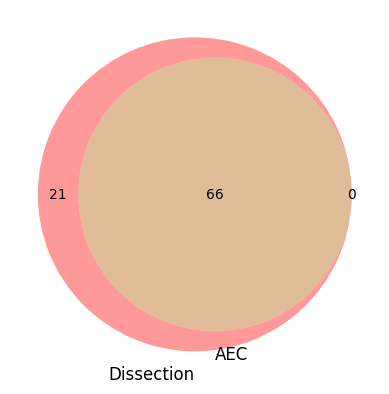

In [16]:
venn2([q2set(dissection_q), q2set(aec_q)], set_labels=["Dissection", "AEC"])

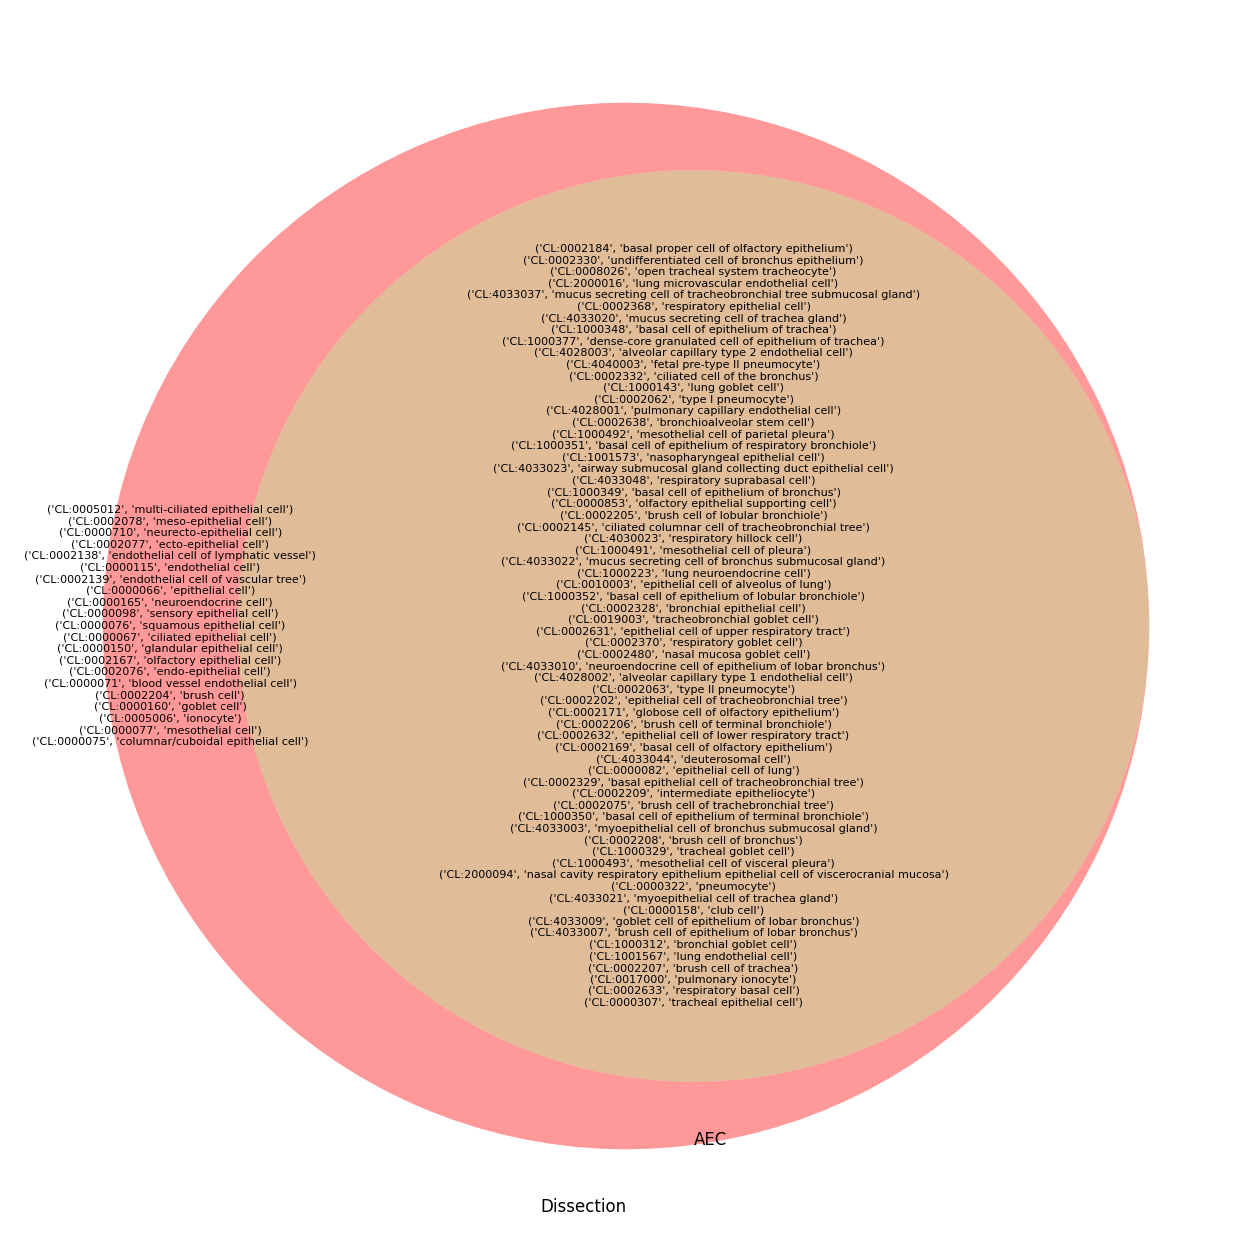

In [17]:
plt.figure(figsize=(24, 16))
venn_axis = venn2([q2set(dissection_q), q2set(aec_q)], set_labels=["Dissection", "AEC"])
only_set1 = q2set(dissection_q) - q2set(aec_q)
only_set2 = q2set(aec_q) - q2set(dissection_q)
common_set = q2set(dissection_q) & q2set(aec_q)
venn_axis.get_label_by_id('10').set_text('\n'.join(map(str, only_set1)))
venn_axis.get_label_by_id('01').set_text('\n'.join(map(str, only_set2)))
venn_axis.get_label_by_id('11').set_text('\n'.join(map(str, common_set)))

# Adjust position and size of the labels (optional)
for id in ('10', '01', '11'):
    label = venn_axis.get_label_by_id(id)
    if label:
        label.set_fontsize(8)


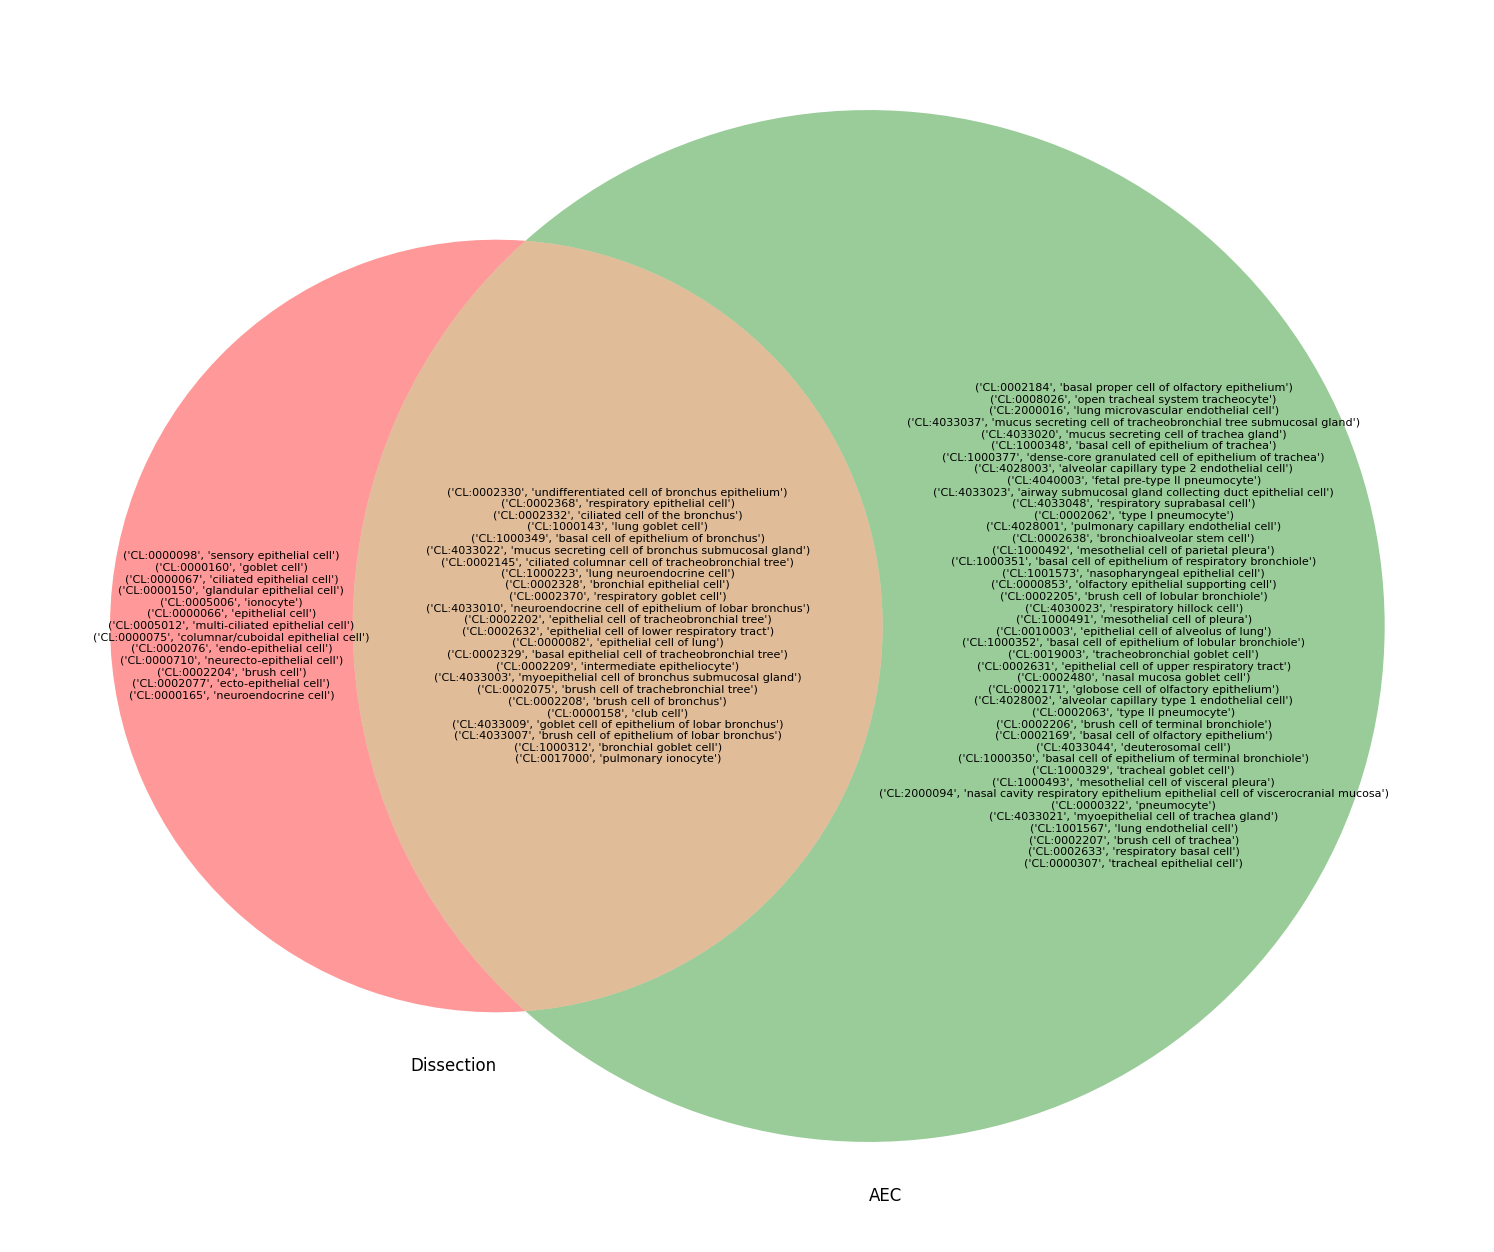

In [33]:
def dissection_venn(struct: str):
    plt.figure(figsize=(24, 16))
    my_dissection_q = ancestor_of(descendant_of(struct, predicates=[PART_OF]), predicates=[HAS_PART]) & epithelial_q
    venn_axis = venn2([q2set(my_dissection_q), q2set(aec_q)], set_labels=["Dissection", "AEC"])
    only_set1 = q2set(my_dissection_q) - q2set(aec_q)
    only_set2 = q2set(aec_q) - q2set(my_dissection_q)
    common_set = q2set(my_dissection_q) & q2set(aec_q)
    venn_axis.get_label_by_id('10').set_text('\n'.join(map(str, only_set1)))
    venn_axis.get_label_by_id('01').set_text('\n'.join(map(str, only_set2)))
    venn_axis.get_label_by_id('11').set_text('\n'.join(map(str, common_set)))
    
    # Adjust position and size of the labels (optional)
    for id in ('10', '01', '11'):
        label = venn_axis.get_label_by_id(id)
        if label:
            label.set_fontsize(8)
            
dissection_venn("bronchus")

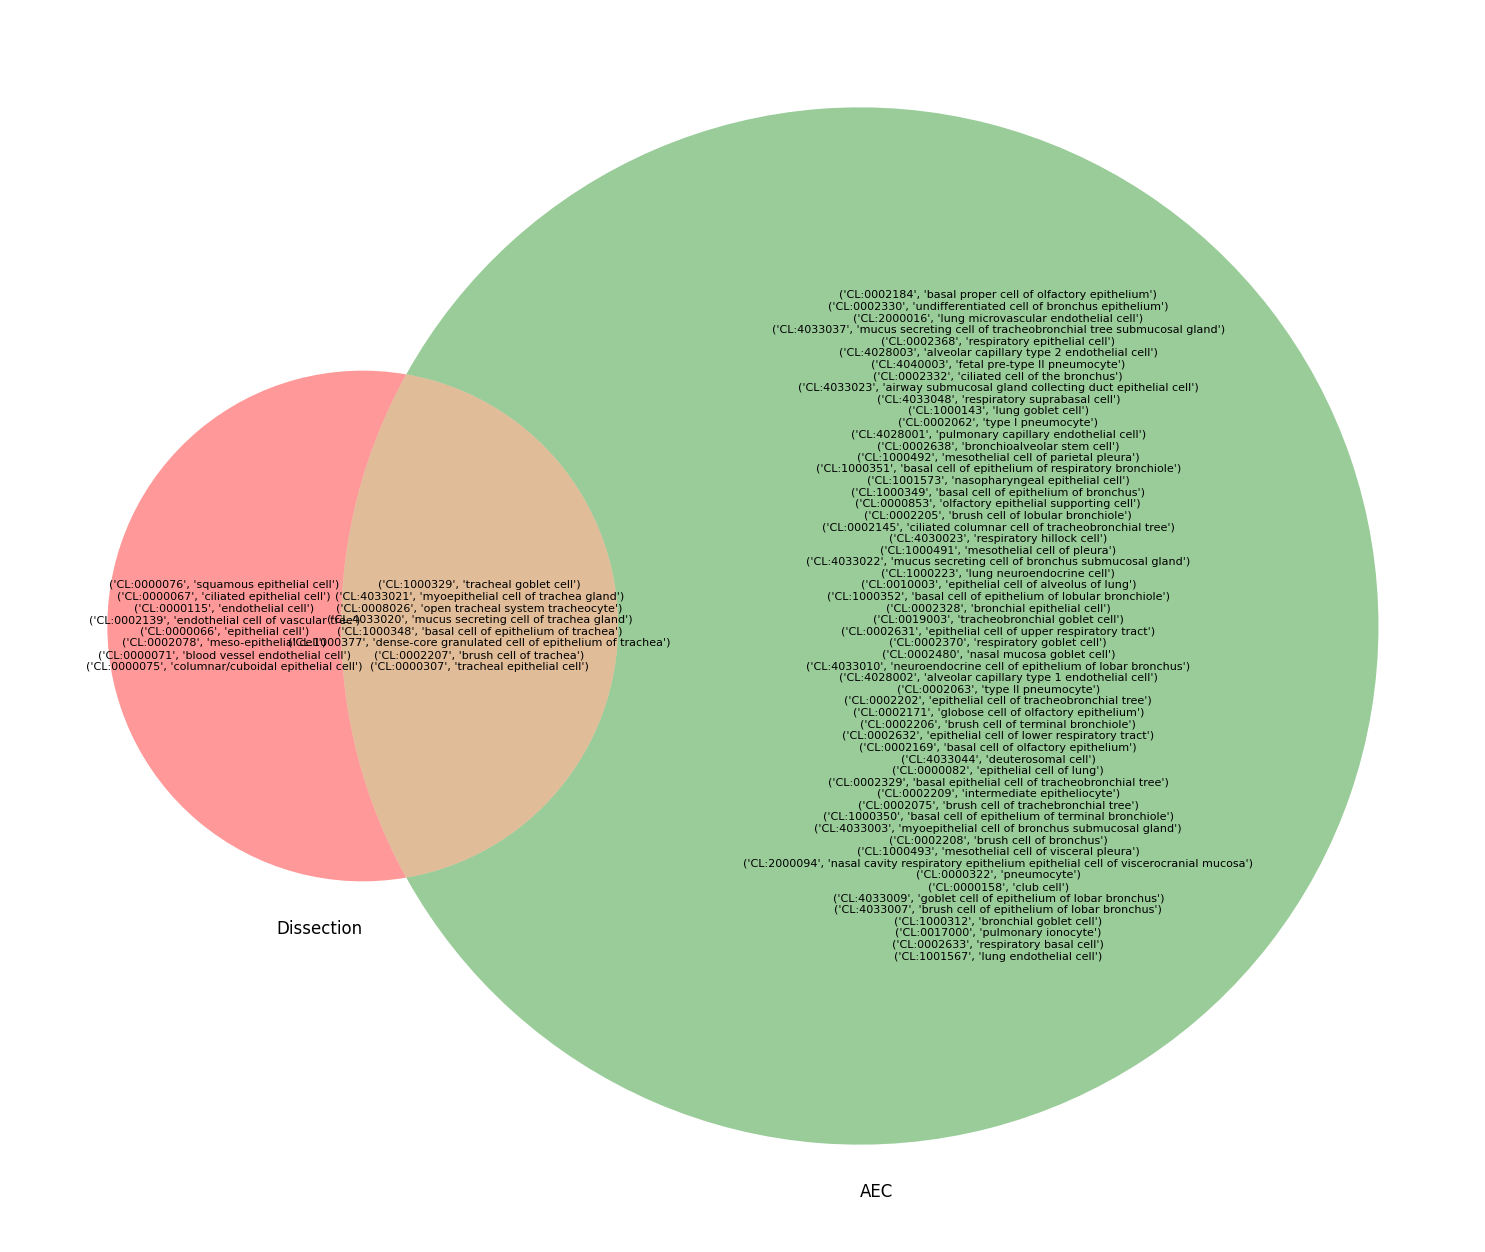

In [34]:
dissection_venn("trachea")


## Roll ups
            

In [18]:
from oaklib.utilities.axioms.logical_definition_utilities import roll_up_to_genus

aec_minimal = {roll_up_to_genus(t, cl, [PART_OF]) for t in aec_q.execute(cl)}
aec_minimal_df = pd.DataFrame((t, cl.label(t)) for t in aec_minimal)
aec_minimal_df

0                                                  1
0   CL:0002062                                  type I pneumocyte
1   CL:4033044                                  deuterosomal cell
2   CL:0000630                                    supporting cell
3   CL:0000064                                      ciliated cell
4   CL:0002145    ciliated columnar cell of tracheobronchial tree
5   CL:1000441           epithelial cell of viscerocranial mucosa
6   CL:0002638                         bronchioalveolar stem cell
7   CL:0002139                  endothelial cell of vascular tree
8   CL:0002184          basal proper cell of olfactory epithelium
9   CL:4028003         alveolar capillary type 2 endothelial cell
10  CL:0002329     basal epithelial cell of tracheobronchial tree
11  CL:0002167                          olfactory epithelial cell
12  CL:0002076                               endo-epithelial cell
13  CL:0002066                                       Feyrter cell
14  CL:0000076                           squamous epithelial cell
15  CL:4030024                                       hillock cell
16  CL:0017000                                 pulmonary ionocyte
17  CL:4040003                       fetal pre-type II pneumocyte
18  CL:0002171               globose cell of olfactory epithelium
19  CL:0000160                                        goblet cell
20  CL:4033023  airway submucosal gland collecting duct epithe...
21  CL:4033048                        respiratory suprabasal cell
22  CL:0000066                                    epithelial cell
23  CL:0000165                                neuroendocrine cell
24  CL:0000322                                         pneumocyte
25  CL:0002633                             respiratory basal cell
26  CL:0002330       undifferentiated cell of bronchus epithelium
27  CL:0002209                         intermediate epitheliocyte
28  CL:0002063                                 type II pneumocyte
29  CL:0000319                               mucus secreting cell
30  CL:0002204                                         brush cell
31  CL:4033037  mucus secreting cell of tracheobronchial tree ...
32  CL:4028002         alveolar capillary type 1 endothelial cell
33  CL:0000158                                          club cell
34  CL:0000077                                   mesothelial cell
35  CL:0000185                                 myoepithelial cell

In [22]:
LOCS = ["lower respiratory tract", "upper respiratory tract", "trachea", "bronchus", "alveolus", "lung", "nose"]

by_loc = {loc: (subclass_of("epithelial cell") & descendant_of(loc, predicates=[PART_OF])).execute(cl) for loc in LOCS}
print(len(by_loc))
by_genus = {cell: subclass_of(cell).execute(cl) for cell in aec_minimal}
print(len(by_genus))


7
36


AttributeError: 'list' object has no attribute 'intersection'

In [28]:
rows = []
for cell in aec_minimal:
    row = {"id": cell, "label": cl.label(cell)}
    for loc in LOCS:
        num = len(set(by_loc[loc]).intersection(by_genus[cell]))
        row[loc] = 1 if num > 0 else 0
    rows.append(row)

xp_df = pd.DataFrame(rows)
xp_df

id                                              label  \
0   CL:0002062                                  type I pneumocyte   
1   CL:4033044                                  deuterosomal cell   
2   CL:0000630                                    supporting cell   
3   CL:0000064                                      ciliated cell   
4   CL:0002145    ciliated columnar cell of tracheobronchial tree   
5   CL:1000441           epithelial cell of viscerocranial mucosa   
6   CL:0002638                         bronchioalveolar stem cell   
7   CL:0002139                  endothelial cell of vascular tree   
8   CL:0002184          basal proper cell of olfactory epithelium   
9   CL:4028003         alveolar capillary type 2 endothelial cell   
10  CL:0002329     basal epithelial cell of tracheobronchial tree   
11  CL:0002167                          olfactory epithelial cell   
12  CL:0002076                               endo-epithelial cell   
13  CL:0002066                                       Feyrter cell   
14  CL:0000076                           squamous epithelial cell   
15  CL:4030024                                       hillock cell   
16  CL:0017000                                 pulmonary ionocyte   
17  CL:4040003                       fetal pre-type II pneumocyte   
18  CL:0002171               globose cell of olfactory epithelium   
19  CL:0000160                                        goblet cell   
20  CL:4033023  airway submucosal gland collecting duct epithe...   
21  CL:4033048                        respiratory suprabasal cell   
22  CL:0000066                                    epithelial cell   
23  CL:0000165                                neuroendocrine cell   
24  CL:0000322                                         pneumocyte   
25  CL:0002633                             respiratory basal cell   
26  CL:0002330       undifferentiated cell of bronchus epithelium   
27  CL:0002209                         intermediate epitheliocyte   
28  CL:0002063                                 type II pneumocyte   
29  CL:0000319                               mucus secreting cell   
30  CL:0002204                                         brush cell   
31  CL:4033037  mucus secreting cell of tracheobronchial tree ...   
32  CL:4028002         alveolar capillary type 1 endothelial cell   
33  CL:0000158                                          club cell   
34  CL:0000077                                   mesothelial cell   
35  CL:0000185                                 myoepithelial cell   

    lower respiratory tract  upper respiratory tract  trachea  bronchus  \
0                         1                        0        0         0   
1                         0                        0        0         0   
2                         0                        1        0         0   
3                         1                        0        0         1   
4                         1                        0        0         1   
5                         0                        1        0         0   
6                         1                        0        0         0   
7                         1                        0        0         0   
8                         0                        1        0         0   
9                         1                        0        0         0   
10                        1                        0        0         1   
11                        0                        1        0         0   
12                        1                        1        1         1   
13                        1                        0        1         0   
14                        1                        0        0         0   
15                        0                        0        0         0   
16                        1                        0        0         0   
17                        1                        0        0         0   
18                        0      

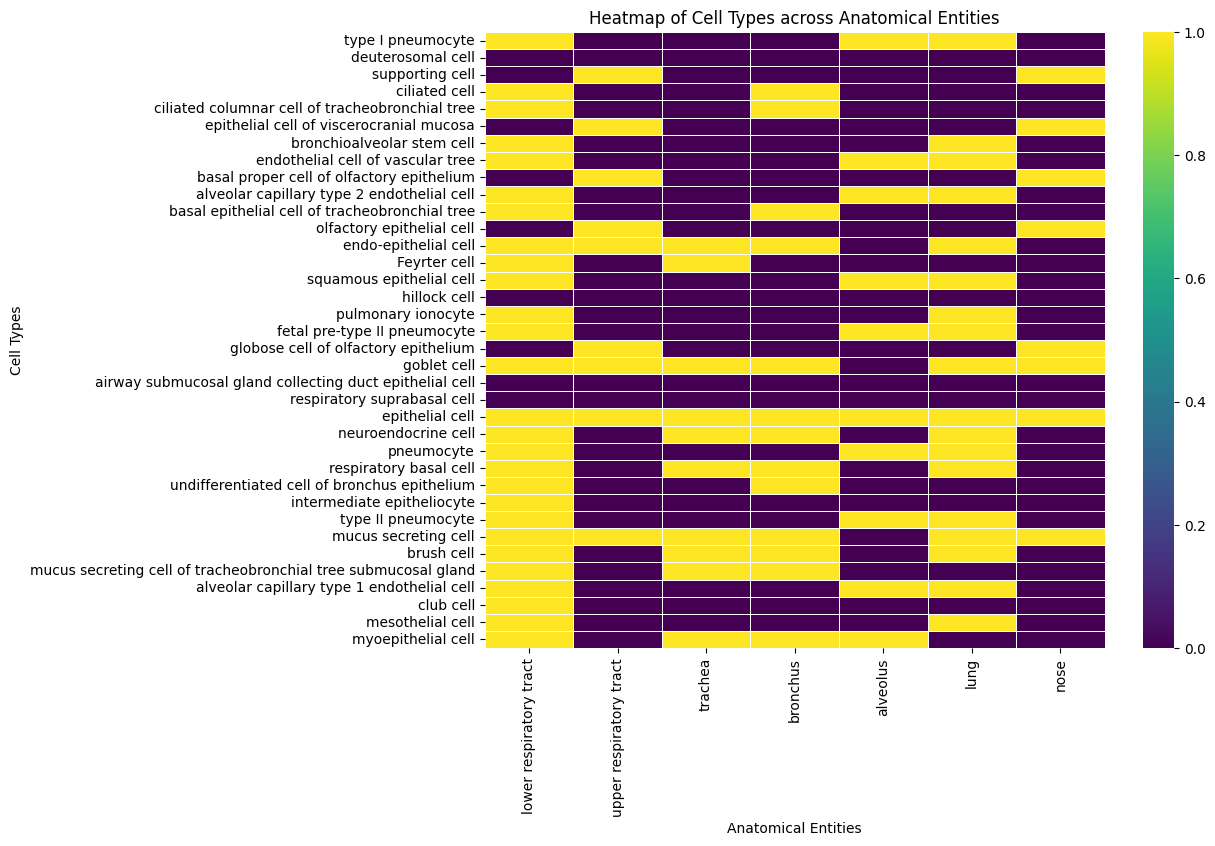

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Assuming df is your dataframe with 'id' and 'label' columns followed by columns of anatomical entities
# Set 'id' or 'label' as the index if it makes it easier to visualize
xp_df.set_index('label', inplace=True)

plt.figure(figsize=(10, 8))
sns.heatmap(xp_df.iloc[:, 1:], cmap='viridis', cbar=True, linewidths=.5)
plt.xlabel('Anatomical Entities')
plt.ylabel('Cell Types')
plt.title('Heatmap of Cell Types across Anatomical Entities')
plt.show()

In [46]:
hp_by_loc = {}
for loc in LOCS:
    hp_by_loc[loc] = set(ancestor_of(descendant_of(loc, predicates=[PART_OF]) - subclass_of("cell"), predicates=[HAS_PART]).execute(cl))

In [47]:
rows = []
for cell in aec_minimal:
    row = {"id": cell, "label": cl.label(cell)}
    cells = set(subclass_of(cell).execute(cl))
    for loc in LOCS:
        num = len(cells.intersection(hp_by_loc[loc]))
        row[loc] = 1 if num > 0 else 0
    rows.append(row)


hp_df = pd.DataFrame(rows)
hp_df

id                                              label  \
0   CL:0002062                                  type I pneumocyte   
1   CL:4033044                                  deuterosomal cell   
2   CL:0000630                                    supporting cell   
3   CL:0000064                                      ciliated cell   
4   CL:0002145    ciliated columnar cell of tracheobronchial tree   
5   CL:1000441           epithelial cell of viscerocranial mucosa   
6   CL:0002638                         bronchioalveolar stem cell   
7   CL:0002139                  endothelial cell of vascular tree   
8   CL:0002184          basal proper cell of olfactory epithelium   
9   CL:4028003         alveolar capillary type 2 endothelial cell   
10  CL:0002329     basal epithelial cell of tracheobronchial tree   
11  CL:0002167                          olfactory epithelial cell   
12  CL:0002076                               endo-epithelial cell   
13  CL:0002066                                       Feyrter cell   
14  CL:0000076                           squamous epithelial cell   
15  CL:4030024                                       hillock cell   
16  CL:0017000                                 pulmonary ionocyte   
17  CL:4040003                       fetal pre-type II pneumocyte   
18  CL:0002171               globose cell of olfactory epithelium   
19  CL:0000160                                        goblet cell   
20  CL:4033023  airway submucosal gland collecting duct epithe...   
21  CL:4033048                        respiratory suprabasal cell   
22  CL:0000066                                    epithelial cell   
23  CL:0000165                                neuroendocrine cell   
24  CL:0000322                                         pneumocyte   
25  CL:0002633                             respiratory basal cell   
26  CL:0002330       undifferentiated cell of bronchus epithelium   
27  CL:0002209                         intermediate epitheliocyte   
28  CL:0002063                                 type II pneumocyte   
29  CL:0000319                               mucus secreting cell   
30  CL:0002204                                         brush cell   
31  CL:4033037  mucus secreting cell of tracheobronchial tree ...   
32  CL:4028002         alveolar capillary type 1 endothelial cell   
33  CL:0000158                                          club cell   
34  CL:0000077                                   mesothelial cell   
35  CL:0000185                                 myoepithelial cell   

    lower respiratory tract  upper respiratory tract  trachea  bronchus  \
0                         1                        0        0         0   
1                         0                        0        0         0   
2                         1                        1        0         0   
3                         1                        1        1         1   
4                         1                        0        0         1   
5                         0                        0        0         0   
6                         0                        0        0         0   
7                         1                        0        1         0   
8                         0                        0        0         0   
9                         0                        0        0         0   
10                        1                        0        0         1   
11                        0                        1        0         0   
12                        1                        0        0         1   
13                        0                        0        0         0   
14                        1                        0        1         0   
15                        0                        0        0         0   
16                        1                        0        0         1   
17                        0                        0        0         0   
18                        0      

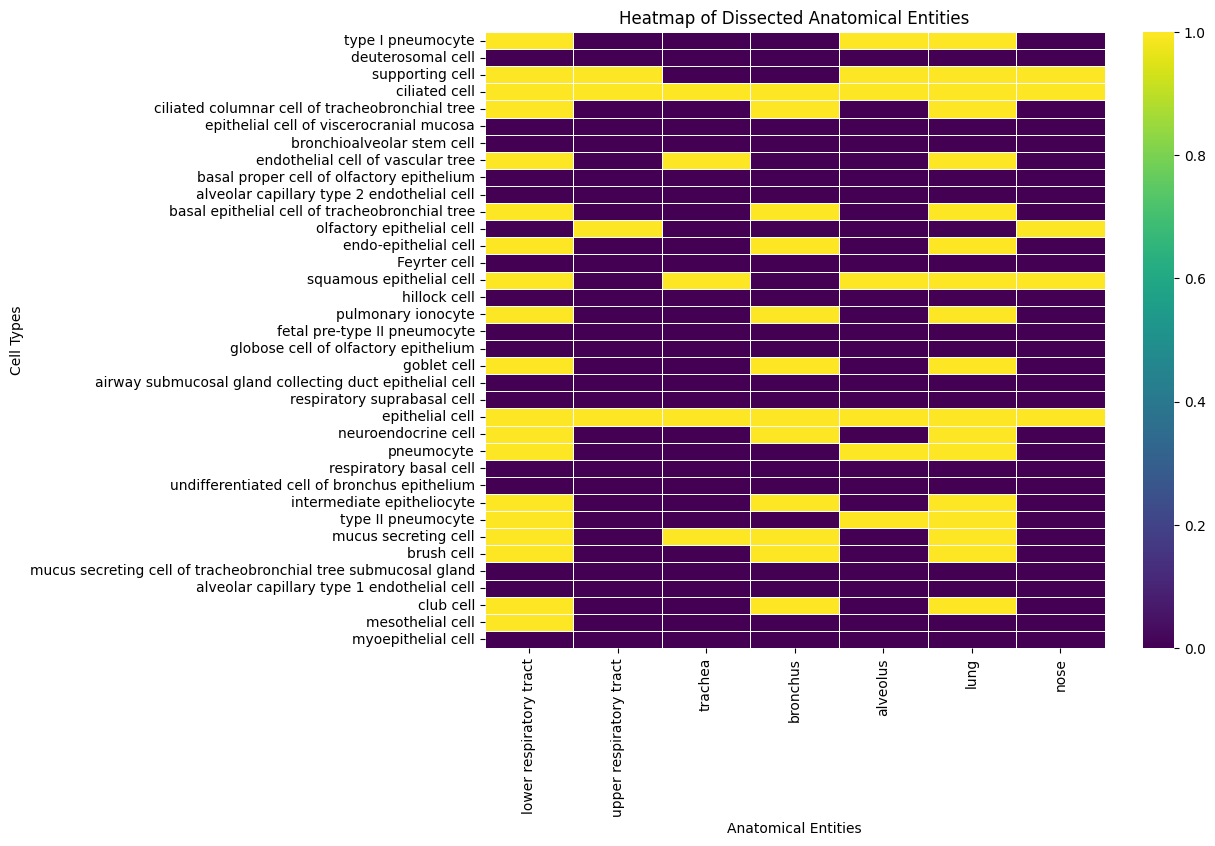

In [48]:
hp_df.set_index('label', inplace=True)

plt.figure(figsize=(10, 8))
sns.heatmap(hp_df.iloc[:, 1:], cmap='viridis', cbar=True, linewidths=.5)
plt.xlabel('Anatomical Entities')
plt.ylabel('Cell Types')
plt.title('Heatmap of Dissected Anatomical Entities')
plt.show()

In [53]:
hp_only_df = hp_df.astype(bool) & ~xp_df.astype(bool)
hp_only_df

id  \
label                                                       
type I pneumocyte                                   False   
deuterosomal cell                                   False   
supporting cell                                     False   
ciliated cell                                       False   
ciliated columnar cell of tracheobronchial tree     False   
epithelial cell of viscerocranial mucosa            False   
bronchioalveolar stem cell                          False   
endothelial cell of vascular tree                   False   
basal proper cell of olfactory epithelium           False   
alveolar capillary type 2 endothelial cell          False   
basal epithelial cell of tracheobronchial tree      False   
olfactory epithelial cell                           False   
endo-epithelial cell                                False   
Feyrter cell                                        False   
squamous epithelial cell                            False   
hillock cell                                        False   
pulmonary ionocyte                                  False   
fetal pre-type II pneumocyte                        False   
globose cell of olfactory epithelium                False   
goblet cell                                         False   
airway submucosal gland collecting duct epithel...  False   
respiratory suprabasal cell                         False   
epithelial cell                                     False   
neuroendocrine cell                                 False   
pneumocyte                                          False   
respiratory basal cell                              False   
undifferentiated cell of bronchus epithelium        False   
intermediate epitheliocyte                          False   
type II pneumocyte                                  False   
mucus secreting cell                                False   
brush cell                                          False   
mucus secreting cell of tracheobronchial tree s...  False   
alveolar capillary type 1 endothelial cell          False   
club cell                                           False   
mesothelial cell                                    False   
myoepithelial cell                                  False   

                                                    lower respiratory tract  \
label                                                                         
type I pneumocyte                                                     False   
deuterosomal cell                                                     False   
supporting cell                                                        True   
ciliated cell                                                         False   
ciliated columnar cell of tracheobronchial tree                       False   
epithelial cell of viscerocranial mucosa                              False   
bronchioalveolar stem cell                                            False   
endothelial cell of vascular tree                                     False   
basal proper cell of olfactory epithelium                             False   
alveolar capillary type 2 endothelial cell                            False   
basal epithelial cell of tracheobronchial tree                        False   
olfactory epithelial cell                                             False   
endo-epithelial cell                                                  False   
Feyrter cell                                                          False   
squamous epithelial cell                                              False   
hillock cell                                                          False   
pulmonary ionocyte                                                    False   
fetal pre-type II pneumocyte                                          False   
globose cell of olfactory epithelium                                  False   
goblet cell                                                           False  

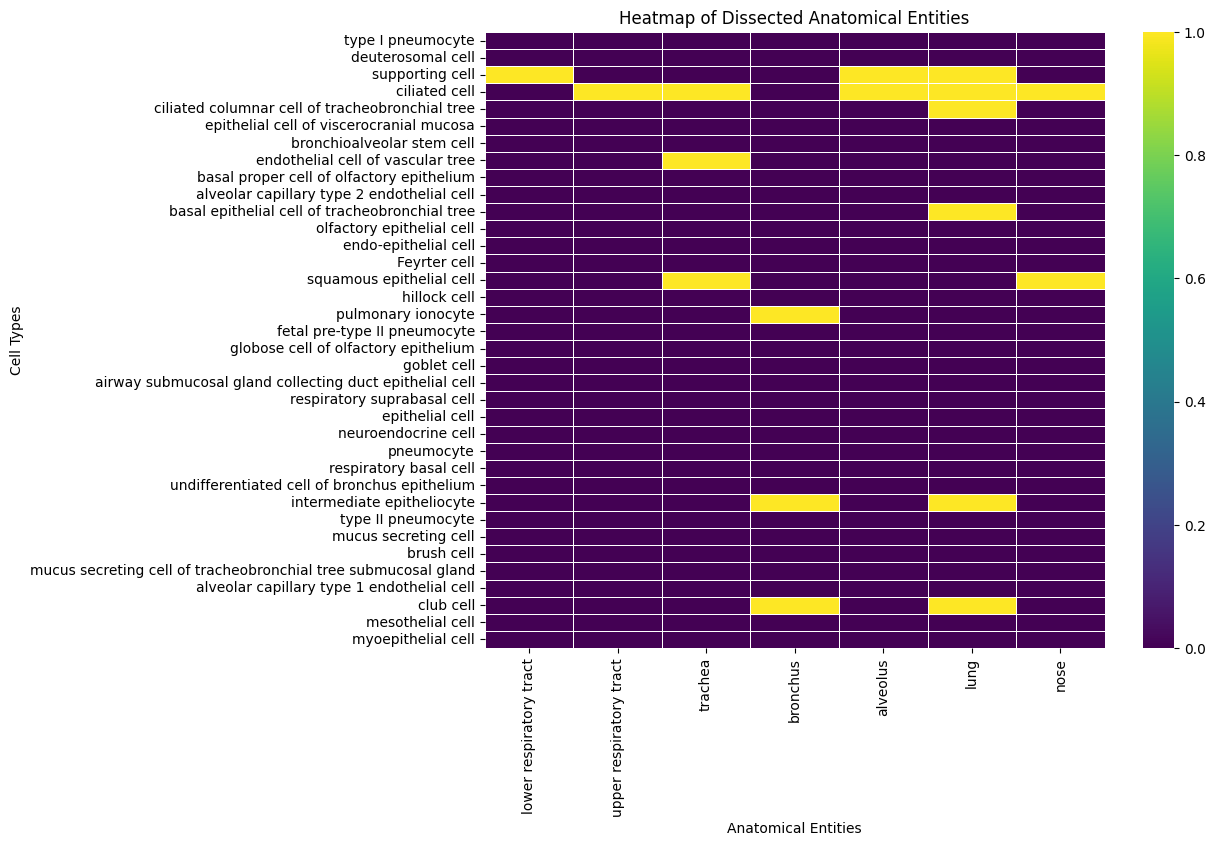

In [55]:
#hp_only_df.set_index('label', inplace=True)

plt.figure(figsize=(10, 8))
sns.heatmap(hp_only_df.iloc[:, 1:], cmap='viridis', cbar=True, linewidths=.5)
plt.xlabel('Anatomical Entities')
plt.ylabel('Cell Types')
plt.title('Heatmap of Dissected Anatomical Entities')
plt.show()